# Heart Disease Classification - Introduction

<img width="600" height="" align="left" src="https://healthblog.uofmhealth.org/sites/consumer/files/2020-01/heart_beating_0.gif">

Heart disease refers to several different heart conditions, such as coronary heart disease, heart attack, congestive heart failure, and congenital heart disease. It is the leading cause of death around the world.

Preventative measures is often the best cure and understanding the signs of at-risk patients can be very helpful for the prognosis. 

Heart disease generally presents itself quite differently in men and women. One of the major challenges for diagnosing women with heart disease is the lack of recognition of symptoms related to heart disease, or that they don't fit the classic definitions due to more data available for heart disease in men compared to women. Often times women can develop symptoms that are subtler and harder to detect as a heart attack.

**Main Goal:**
Using this dataset of patient information for common factors related to heart disease, we are building a model to evaluate what are the most important factors for diagnosing heart disease in men and women to illustrate how they differ based on gender. 

## Getting Started

### Importing libraries and models

In [1]:
# import libraries required
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

# import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# import evaluation functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

# matplotlib for plotting modification
import matplotlib.pyplot as plt
%matplotlib inline

# scikitplot to directly plot our results
import graphviz
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

### Loading our dataset and clean-up

In [2]:
# Loading our csv into python
df = pd.read_csv('heart.csv')
# Rename our columns so they're more descriptive
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol', 'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_induced_angina', 'oldpeak', 'slope', 'num_major_vessels', 'thallium', 'heart_disease']
# Taking a look at the first few rows of the table
df.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,oldpeak,slope,num_major_vessels,thallium,heart_disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


A lot of the values above are denoted as integers and aren't really descriptive. To make the values more meaningful for our exploratory data analysis, let's replace them using the dictionaries below.

In [3]:
# Create a copy of the original table to use for exploratory data analysis
df_category = df.copy()

# Replace values in the columns below using these dictionaries
df_category.replace({'heart_disease': {0: 'no heart disease', 1: 'heart disease'}},inplace=True)
df_category.replace({'sex': {0: 'female', 1: 'male'}}, inplace=True)
df_category.replace({'chest_pain_type': {0: 'asymptomatic', 1: 'atypical angina', 2: 'non anginal pain', 3: 'typical angina'}}, inplace=True)
df_category.replace({'fasting_blood_sugar': {0: '<120 mg/dl', 1: '>120 mg/dl'}}, inplace=True)
df_category.replace({'resting_ecg': {0: 'left ventricular hypertrophy', 1: 'normal', 2: 'ST-T wave abnormality'}}, inplace=True)
df_category.replace({'exercise_induced_angina': {0: 'no exercise-induced angina', 1: 'exercise-induced angina'}}, inplace=True)
df_category.replace({'slope': {0: 'downsloping', 1: 'flat', 2: 'upsloping'}}, inplace=True)
df_category.replace({'thallium': {0: 'none', 1: 'fixed defect', 2: 'normal', 3: 'reversible defect'}}, inplace=True)

In [4]:
# Quick look at the new table
df_category.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,oldpeak,slope,num_major_vessels,thallium,heart_disease
0,63,male,typical angina,145,233,>120 mg/dl,left ventricular hypertrophy,150,no exercise-induced angina,2.3,downsloping,0,fixed defect,heart disease
1,37,male,non anginal pain,130,250,<120 mg/dl,normal,187,no exercise-induced angina,3.5,downsloping,0,normal,heart disease
2,41,female,atypical angina,130,204,<120 mg/dl,left ventricular hypertrophy,172,no exercise-induced angina,1.4,upsloping,0,normal,heart disease
3,56,male,atypical angina,120,236,<120 mg/dl,normal,178,no exercise-induced angina,0.8,upsloping,0,normal,heart disease
4,57,female,asymptomatic,120,354,<120 mg/dl,normal,163,exercise-induced angina,0.6,upsloping,0,normal,heart disease


# Exploratory Data Analysis

For our exploratory data analysis, we will be going through each of the factors related to heart disease from the dataset. In particular we will explore the differences we might see between women with heart disease as compared to men with heart disease.

## General Population Distribution

We see below that there is a relatively even distribution for the presence of heart disease in our patient dataset.

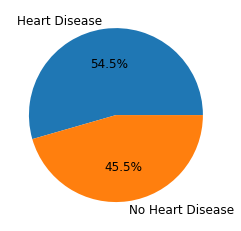

In [5]:
HeartDisease = df_category.groupby('heart_disease').size()
plt.pie(HeartDisease.values, labels = ['Heart Disease', 'No Heart Disease'], autopct='%1.1f%%', textprops = {'fontsize' : 12})
plt.show()

When broken down based on gender however, we see some imbalance in the distribution (as shown below). For our female cohort there appears to be a much higher percentage of patients with heart disease. This will be something we will need to keep in mind when tuning our model.

In [6]:
# Looking at the gender distribution in our dataset for those with or without heart disease
Gender = df_category.groupby(['sex','heart_disease']).size().to_frame().reset_index()
Gender.rename(columns = {0:'num'}, inplace = True)
Gender

,sex,heart_disease,num
0,female,heart disease,72
1,female,no heart disease,24
2,male,heart disease,93
3,male,no heart disease,114


<AxesSubplot:xlabel='sex', ylabel='num'>

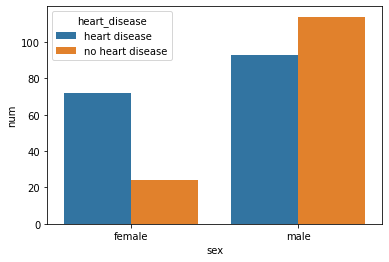

In [7]:
sns.barplot(x = Gender['sex'], y = Gender['num'], hue = Gender['heart_disease'])

## Comparing men and women along each factor

### Age
We see that women with heart disease tend to lean more towards the higher age range as compared men. This is consistent with scientific studies that have shown heart disease usually presents itself in women at an older age.

<AxesSubplot:xlabel='age', ylabel='Count'>

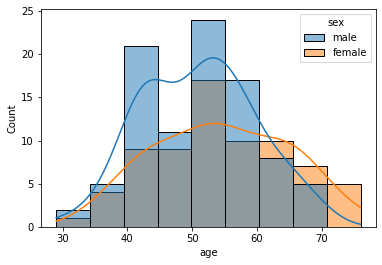

In [8]:
sns.histplot(df_category[df_category['heart_disease']=='heart disease'], x = 'age', hue = 'sex', kde=True)

### Chest Pain Type
There are three criteria for classifying different types of chest pain (also referred to as angina):
- *Location*: Chest pain occurs around the substernal portion of the body
- *Cause*: Pain is experienced resulting from emotional/physical stress
- *Relief*: The pain goes away after taking nitroglycerine and/or a rest

For our dataset, the values were defined as followed: 
- 0: Typical angina (all three criteria present)
- 1: Atypical angina (two criteria satisfied)
- 2: Non-anginal pain (one criteria satisfied)
- 3: Asymptomatic (none of the criteria are satisfied)

Men and women appear to have quite similar distributions, although typical and atypical angina seems to be more prevalent among men compared to women. This again is consistent with literature where women can often experience other symptoms during a heart attack such as shortness of breath, dizziness, light-headedness or fainting.

([0, 1, 2, 3],
 [Text(0, 0, 'typical angina'),
  Text(1, 0, 'non anginal pain'),
  Text(2, 0, 'atypical angina'),
  Text(3, 0, 'asymptomatic')])

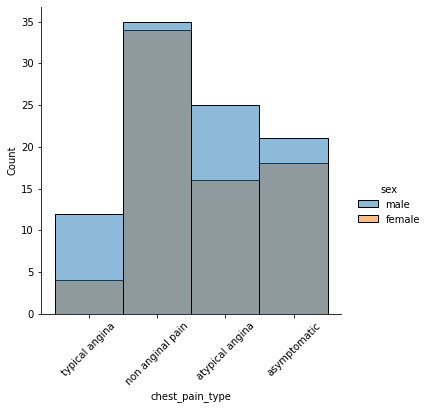

In [9]:
sns.displot(df_category[df_category['heart_disease']=='heart disease'], x = 'chest_pain_type', hue = 'sex')
plt.xticks(rotation=45)

### Resting Blood Pressure (in mmHg)

Higher blood pressure is referred to as hypertension. Those with high blood pressure are more at risk for heart disease. Anything over 120 is considered elevated and if systolic pressure is over 130, this is cause for concern for heart disease. 

The distribution for both men and women in our dataset are on the higher spectrum for resting blood pressure. 

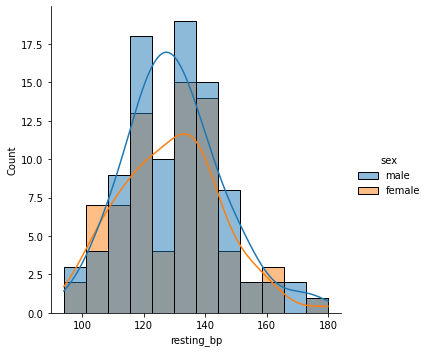

In [10]:
sns.displot(df_category[df_category['heart_disease']=='heart disease'], x = 'resting_bp', hue = 'sex', kde=True)

### Serum Cholesterol (in mg/dL)
If you have too much LDL cholesterol in your blood, it can accumulate inside the walls of blood vessels. AS this builds up, it can turn into a substance called plaque which can narrow and harden arteries and limit blood flow.

We see that cholesterol is higher in women compared to men among our heart disease cohort. Interestingly, women tend to have higher HDL cholesterol than men, which helps to remove cholesterol in the bloodstream (HDL cholesterol positively correlates with estrogen). However, when women hit menopause, their total and LDL cholesterol levels tend to rise and HDL cholesterol tends to fall which means many women who do not have high cholesterol at an early age may develop high cholesterol later in life. This is correlates with heart disease being more present in older women. 

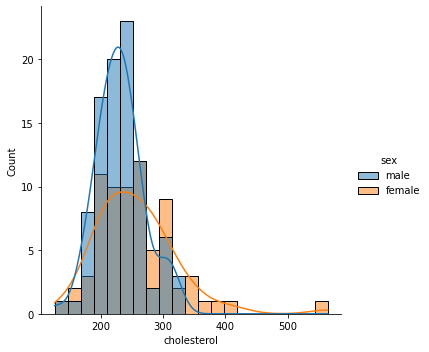

In [11]:
sns.displot(df_category[df_category['heart_disease']=='heart disease'], x = 'cholesterol', hue = 'sex', kde=True)

### Fasting Blood Sugar > 120 mg/dL (likely to be diabetic)
Our data is broken down into those who have fasting blood sugar levels over 120 mg/dL and under 120 mg/dL. Being over 120 mg/dL means they're likely to be diabetic. If you have diabetes, you’re twice as likely to have heart disease or a stroke compared to someone who doesn’t have diabetes.

For our dataset, there doesn't appear to be many individuals with diabetes for both men and women. Although, there does appear to be slightly more diabetic men as compared to women who have heart disease.

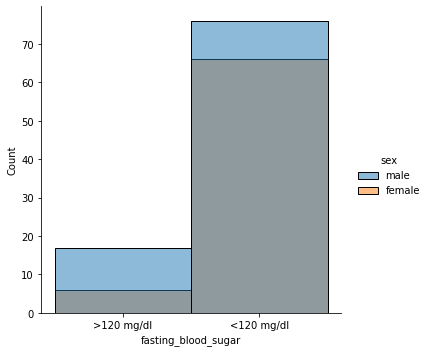

In [12]:
sns.displot(df_category[df_category['heart_disease']=='heart disease'], x = 'fasting_blood_sugar', hue = 'sex')

### Resting Electrocardiographic Results
This is a measure of heart activity. When we look at the resting ECG chart, we can identify peaks and valleys that show when the upper and lower chambers of your heart are contracting and relaxing. Specific heart disorders can produce recognizable patterns on the ECG. 

Relative to their population in this sample, women with heart disease seem to show more signs of irregular ECGs results as compared to men.

([0, 1, 2],
 [Text(0, 0, 'left ventricular hypertrophy'),
  Text(1, 0, 'normal'),
  Text(2, 0, 'ST-T wave abnormality')])

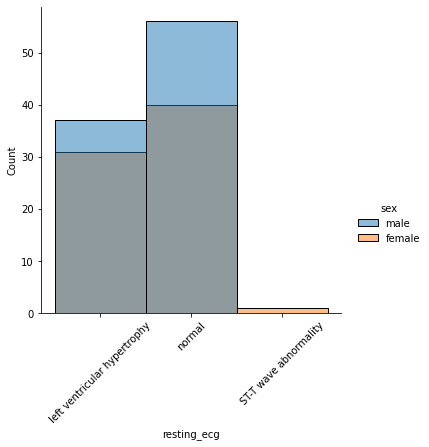

In [13]:
sns.displot(df_category[df_category['heart_disease']=='heart disease'], x = 'resting_ecg', hue = 'sex')
plt.xticks(rotation=45)

### Max Heart Rate
Maximum heart rate is the fastest the heart can beat and effectively pump blood through the body. As you age, your maximum heart rate drops which means that your heart is weaker and more susceptible to damage. Given healthy max heart rates are based on age, we explore that relationship below for both men and women. 

We can see below, compared to the average, a majority of those with heart disease (regardless of gender) fall below the average max heart rate given their age.

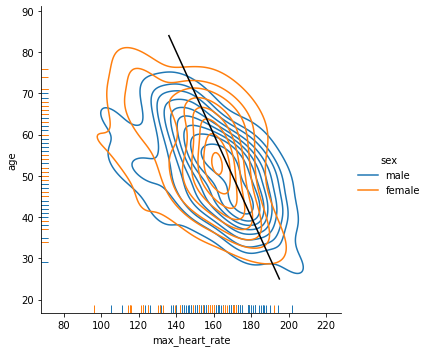

In [14]:
sns.displot(df_category[df_category['heart_disease']=='heart disease'], x = 'max_heart_rate', y = 'age', hue = 'sex', kind="kde", rug=True)

# Line represents the average max heart rate 
x = np.arange(25,85)
plt.plot(220-x, x, 'k-')

### Exercise-Induced Angina

Chest pain (angina) following exercise is a common complaint of those with heart disease given exercise can stress the heart. Based on the information below, we don't see much of a difference in the proportion of men or women experiencing exercise-induced angina when they have heart disease.

([0, 1],
 [Text(0, 0, 'no exercise-induced angina'),
  Text(1, 0, 'exercise-induced angina')])

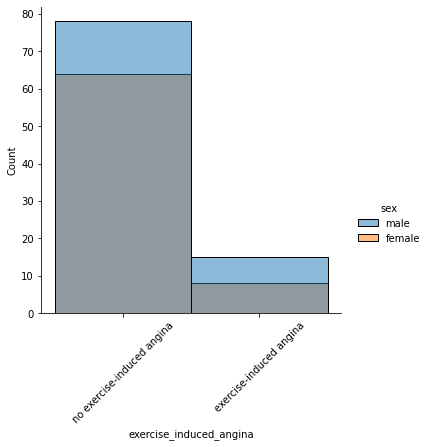

In [15]:
sns.displot(df_category[df_category['heart_disease']=='heart disease'], x = 'exercise_induced_angina', hue = 'sex')
plt.xticks(rotation=45)

### Old Peak of ST Segment (in mm)
Exercise induced ST segment depression is considered a reliable ECG finding for the diagnosis of obstructive coronary atherosclerosis, a gradual narrowing or closing of arteries that supply the heart with blood. ST segments that are more than 1 to 2 mm lower than baseline are termed depressed.

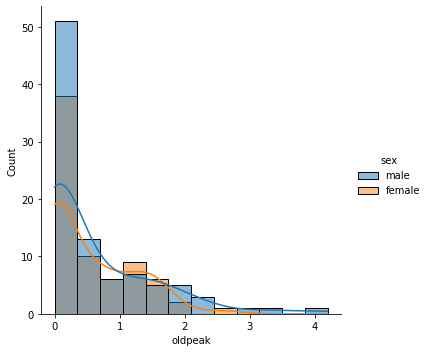

In [16]:
sns.displot(df_category[df_category['heart_disease']=='heart disease'], x = 'oldpeak', hue = 'sex', kde = True)

### Slope of ST Segment
ST segment depressions caused by ischemia are characterized by a flat or downsloping ST segment.

- 0: Downsloping
- 1: Flat
- 2: Upsloping

Having a flat ST segment seems to be more common in women with heart disease as compared to men.

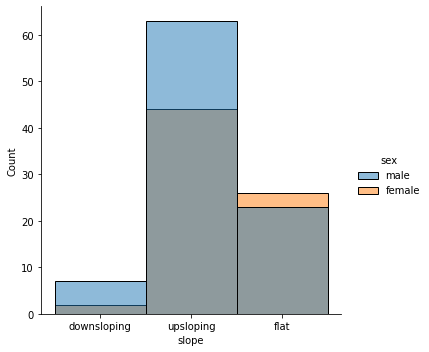

In [17]:
sns.displot(df_category[df_category['heart_disease']=='heart disease'], x = 'slope', hue = 'sex')

### Number of Major Blood Vessels Coloured by Fluoroscopy
Radioactive dye is introduced to the body followed by x-ray imaging to detect any structural abnormalities (such as obstructions) present in the heart. The quantity of vessels colored is positively correlated with presence of heart disease.

([<matplotlib.axis.XTick at 0x25cd3c1a1f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

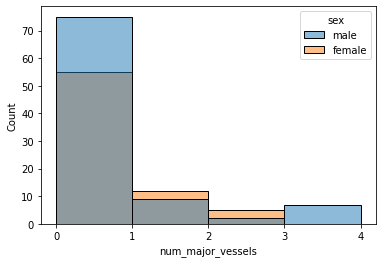

In [18]:
sns.histplot(df_category[df_category['heart_disease']=='heart disease'], x = 'num_major_vessels', hue = 'sex', bins = [0,1,2,3,4])
plt.xticks([0,1,2,3,4])

### Thallium Stress Test
A thallium stress test is a nuclear imaging test that shows how well blood flows into your heart while you’re exercising or at rest.

When patients undergo a thallium stress test, the finding of a reversible defect involving poor blood circulation is used to diagnose weak cardiac muscles, and a fixed thallium defect implies an old infarction (tissue death due to inadequate blood supply to the affected area)

Defects as seen in the thallium stress test are much more prevalent in men compared to women who have heart disease.

([0, 1, 2, 3],
 [Text(0, 0, 'fixed defect'),
  Text(1, 0, 'normal'),
  Text(2, 0, 'reversible defect'),
  Text(3, 0, 'none')])

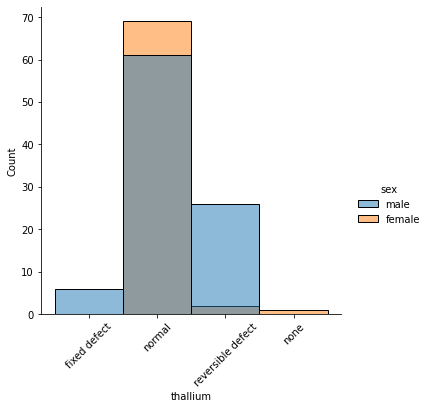

In [19]:
sns.displot(df_category[df_category['heart_disease']=='heart disease'], x = 'thallium', hue = 'sex')
plt.xticks(rotation=45)

## Correlation Between Factors

Let's look at the correlation between each of these factors related to heart disease.

<AxesSubplot:>

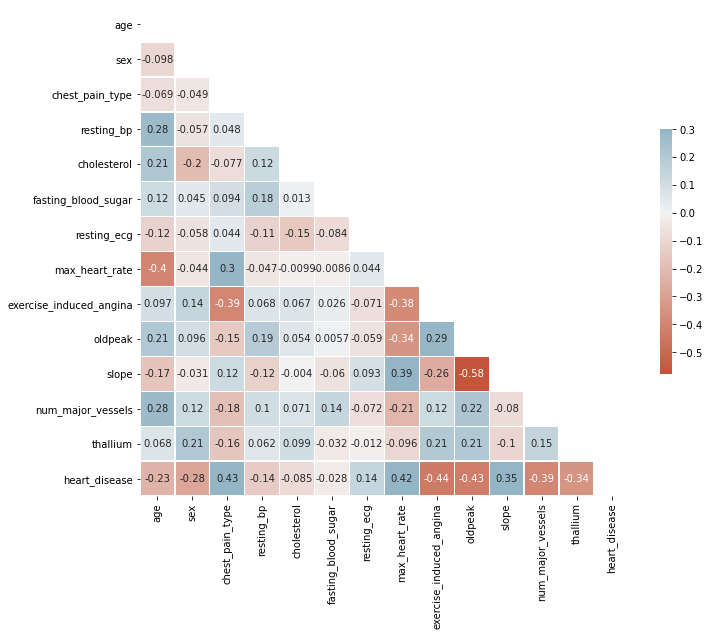

In [20]:
correlation = df.corr()

# Creating a half-matrix for our correlation figure
mask = np.triu(np.ones_like(correlation, dtype=bool))

# General dimension for our plot
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Creating our heatmap for our correlation matrix
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

There are a few factors that do show some correlation, such as Slope and Old Peak which makes sense given they are both measures of ST Segments. However, we don't see a lot of strong correlation between our factors which is good news since we want to avoid multicollinearity in our model.

# Creating our Classification Models

## Reorganizing Dataset

Let's first clean up our dataset a little to account for categorical data and split the dataset based on gender.

In [21]:
# Convert columns with categorical data into category codes for analysis
df_class = df.copy()

df_class['sex'] = df_class['sex'].astype('category')
df_class['chest_pain_type'] = df_class['chest_pain_type'].astype('category')
df_class['fasting_blood_sugar'] = df_class['fasting_blood_sugar'].astype('category')
df_class['resting_ecg'] = df_class['resting_ecg'].astype('category')
df_class['exercise_induced_angina'] = df_class['exercise_induced_angina'].astype('category')
df_class['slope'] = df_class['slope'].astype('category')
df_class['thallium'] = df_class['thallium'].astype('category')
df_class['heart_disease'] = df_class['heart_disease'].astype('category')

df_class.dtypes

age                           int64
sex                        category
chest_pain_type            category
resting_bp                    int64
cholesterol                   int64
fasting_blood_sugar        category
resting_ecg                category
max_heart_rate                int64
exercise_induced_angina    category
oldpeak                     float64
slope                      category
num_major_vessels             int64
thallium                   category
heart_disease              category
dtype: object

In [22]:
# Create individual tables for the female and male data
df_cat_female = df_class[df_class['sex'] == 0]
df_cat_male = df_class[df_class['sex'] == 1]

In [23]:
# Create x and y variables for our female and male datasets
Xf = df_cat_female.drop(labels = ['heart_disease', 'sex'], axis = 1)
yf = df_cat_female['heart_disease']

Xm = df_cat_male.drop(labels = ['heart_disease', 'sex'], axis = 1)
ym = df_cat_male['heart_disease']

In [24]:
# Create training and test datasets for all data, females and males
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.3, random_state=1337)

Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.3, random_state=1337)


## Hyperparameter Tuning
For the purpose of this exercise, we will be using the Random Forest Classifier to create our model. Below are the parameters that we will be working with for our hyperparamater tuning.

In [25]:
# Weighing of classes
weights = np.linspace(0.0,0.99,200)
class_weight = [{0:x, 1:1.0-x} for x in weights]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)]

# Create the random grid
param_grid = {'class_weight': class_weight,
              'n_estimators': n_estimators}


### Females

In [26]:
# Use the GridSearchCV to search for best hyperparameters
# First create the base model to tune
ftest_rf = RandomForestClassifier(random_state = 1337)
# Grid search of parameters
ftest_gridsearch = GridSearchCV(estimator= ftest_rf, param_grid= param_grid, cv=StratifiedKFold(), n_jobs=-1, scoring='f1', verbose=2)
# Fit the random search model
ftest_gridsearch.fit(Xf_train, yf_train)

# Check what the best parameters are based on our GridSearch
ftest_gridsearch.best_params_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


{'class_weight': {0: 0.1691457286432161, 1: 0.8308542713567839},
 'n_estimators': 111}

              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.91      0.91      0.91        22

    accuracy                           0.86        29
   macro avg       0.81      0.81      0.81        29
weighted avg       0.86      0.86      0.86        29



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

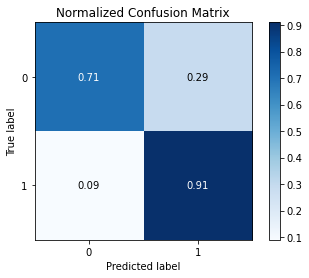

In [27]:
# We will now fit the best parameters onto our dataset
fbest_grid = ftest_gridsearch.best_estimator_
fbest_grid.fit(Xf_train, yf_train)

# Next we test our model on our test dataset to see how accurately it can predict the presence of heart disease
fgrid_pred = fbest_grid.predict(Xf_test)
print(classification_report(yf_test, fgrid_pred))
skplt.metrics.plot_confusion_matrix(yf_test, fgrid_pred, normalize = True)

Our results are fairly accurate, although it does seem to perform better in predicting heart disease as opposed to those without heart disease. This is expected given the imbalance in data but we did account for this when we did our hyperparameter tuning for the class weights.

### Males

In [28]:
# Use the GridSearchCV to search for best hyperparameters
# First create the base model to tune
mtest_rf = RandomForestClassifier(random_state = 1337)
# Grid search of parameters
mtest_gridsearch = GridSearchCV(estimator= mtest_rf, param_grid= param_grid, cv=StratifiedKFold(), n_jobs=-1, scoring='f1', verbose=2)
# Fit the random search model
mtest_gridsearch.fit(Xm_train, ym_train)

# Check what the best parameters are based on our GridSearch
mtest_gridsearch.best_params_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


{'class_weight': {0: 0.6616582914572865, 1: 0.3383417085427135},
 'n_estimators': 177}

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        34
           1       0.72      0.72      0.72        29

    accuracy                           0.75        63
   macro avg       0.74      0.74      0.74        63
weighted avg       0.75      0.75      0.75        63



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

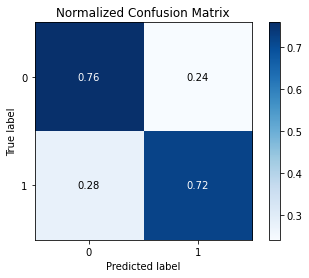

In [29]:
# We will now fit the best parameters onto our dataset
mbest_grid = mtest_gridsearch.best_estimator_
mbest_grid.fit(Xm_train, ym_train)

# Next we test our model on our test dataset to see how accurately it can predict the presence of heart disease
mgrid_pred = mbest_grid.predict(Xm_test)
print(classification_report(ym_test, mgrid_pred))
skplt.metrics.plot_confusion_matrix(ym_test, mgrid_pred, normalize = True)

This model seems to perform a little less accurately compared to our model for females, although the distribution between those with or without heart disease is more balanced. It is still relatively accurate in predicting the presence of heart disease in men. 

# Comparing Important Features for Males vs Females

<AxesSubplot:title={'center':'Feature Importance for Males'}>

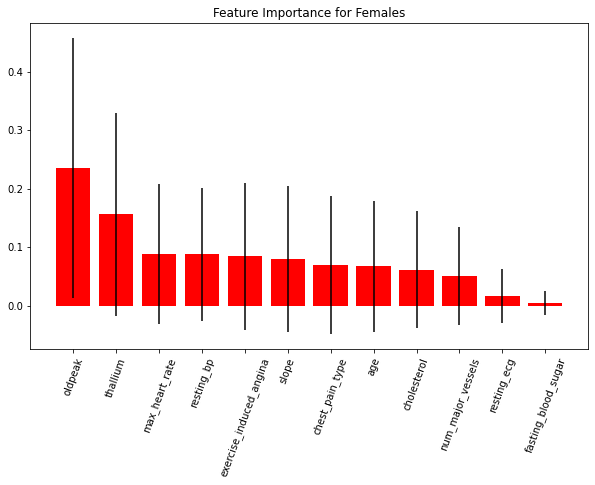

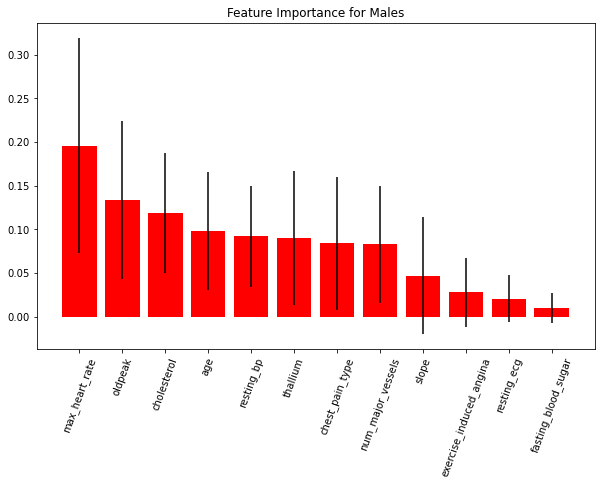

In [30]:
feature_names = df_cat_female.drop(labels = ['heart_disease', 'sex'], axis = 1).columns

skplt.estimators.plot_feature_importances(fbest_grid, feature_names=feature_names, figsize=(10, 6), x_tick_rotation=70, title = "Feature Importance for Females")
skplt.estimators.plot_feature_importances(mbest_grid, feature_names=feature_names, figsize=(10, 6), x_tick_rotation=70, title = "Feature Importance for Males")

For women, the top 5 factors were:
1. Old Peak
2. Thallium Stress Test
3. Max Heart Rate
4. Resting Blood Pressure
5. Exercise-induced Angina

For men, the top 5 factors were:
1. Max Heart Rate
2. Old Peak
3. Cholesterol
4. Age
5. Resting Blood Pressure

# Conclusions

Based on our models, we do see that there are some differences in which factors contribute the most to a diagnosis of heart disease for men versus women. While the Old Peak, Max Heart Rate and Resting Blood Pressure are among the top 5 important features for both genders, it appears that the Thallium Stress Test and Exercise-induced Angina are more important for women in determining if they have heart disease. Interestingly, both of these tests are exercise related and should be taken into consideration when diagnosing heart disease in women.

It's important to note that this is a dataset collected in 1988 with quite a small sample size and has high variance as seen in our feature importance figure above. It would be beneficially to apply this model to a larger dataset that is more recent to see if this still holds true by current health standards.

# Extra Notes

In [31]:
# Exporting data for visualizing in Tableau
important_features_female = list(zip(fbest_grid.feature_importances_, feature_names))
important_features_female = pd.DataFrame(important_features_female,columns=["Importance","Feature_Name"]).to_csv('important_features_female.csv')

important_features_male = list(zip(mbest_grid.feature_importances_, feature_names))
important_features_male = pd.DataFrame(important_features_male,columns=["Importance","Feature_Name"]).to_csv('important_features_male.csv')

df_category.to_csv('heartdisease_categorical.csv')

correlation.to_csv('correlation.csv')